In [1]:
import sys
import copy
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

In [2]:
def count(my_array):
    # Initialize the count
    norm_count = 0
    ano_count = 0

    # Iterate through each element in the list
    for id in my_array:
        if 'normal' in id:
            norm_count += 1
        elif 'anomaly' in id:
            ano_count += 1

    return (ano_count, norm_count)

In [3]:
n_features = 6  # Number of features
sequence_length = 20  # Length of each sequence

df = pd.read_csv('train_inf5050_skip2.csv')
video_ids = df['video_id'].unique()

# Split video IDs into train, validation, and test sets
train_ids, test_ids = train_test_split(video_ids, test_size=0.3, random_state=42)
val_ids = np.concatenate((train_ids[:len(test_ids)], test_ids[:int(0.5*len(test_ids))]))

train_ano_norm = count(train_ids)
val_ano_norm = count(val_ids)
test_ano_norm = count(test_ids)

print('training (anomaly, normal): ', train_ano_norm)
# print('validation (anomaly, normal): ', val_ano_norm)
print('testing (anomaly, normal): ', test_ano_norm)

X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []


for train_id in train_ids:
    filtered_df = df[df['video_id'] == train_id]
    features = filtered_df[['crowd_density', 'loitering', 'no_concealment', 'low_concealment', 'med_concealment', 'high_concealment']]
    RBP = filtered_df['rbp'].iloc[0]
    features = features.to_numpy()
    n_seq = len(features) // sequence_length

    # Reshape the features into batches
    features = features[:sequence_length * n_seq].reshape(-1, sequence_length, n_features) # one video is one batch
    labels = [RBP] * n_seq

    # Extend the lists
    X_train.extend(features)
    y_train.extend(labels)


for val_id in val_ids:
    filtered_df = df[df['video_id'] == val_id]
    features = filtered_df[['crowd_density', 'loitering', 'no_concealment', 'low_concealment', 'med_concealment', 'high_concealment']]
    RBP = filtered_df['rbp'].iloc[0]
    features = features.to_numpy()
    n_seq = len(features) // sequence_length

    # Reshape the features into batches
    features = features[:sequence_length * n_seq].reshape(-1, sequence_length, n_features) # one video is one batch
    labels = [RBP] * n_seq

    # Extend the lists
    X_val.extend(features)
    y_val.extend(labels)


test_n_seq = dict()
for test_id in test_ids:
    filtered_df = df[df['video_id'] == test_id]
    features = filtered_df[['video_id', 'frame_num', 'crowd_density', 'loitering', 'no_concealment', 'low_concealment', 'med_concealment', 'high_concealment']]
    RBP = filtered_df['rbp'].iloc[0]
    features = features.to_numpy()
    n_seq = len(features) // sequence_length
    test_n_seq[test_id] = n_seq


    # Reshape the features into batches
    features = features[:sequence_length * n_seq].reshape(-1, sequence_length, n_features+2) # one video is one batch
    labels = [RBP] * n_seq

    # Extend the lists
    X_test.extend(features)
    y_test.extend(labels)

# Convert to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)


training (anomaly, normal):  (47, 51)
testing (anomaly, normal):  (23, 19)


In [4]:
X_test_features = X_test[:, :, 2:] # features only
X_test_id = X_test[:, :,  :2] # id and frame number

In [5]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(-1, sequence_length, n_features)
X_val_scaled = scaler.transform(X_val.reshape(-1, n_features)).reshape(-1, sequence_length, n_features)
X_test_scaled = scaler.transform(X_test_features.reshape(-1, n_features)).reshape(-1, sequence_length, n_features)

In [6]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

X_test = np.concatenate((X_test_id, X_test_tensor.reshape(-1, sequence_length, n_features)), axis=2)

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Single output neuron for binary classification
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for binary classification

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.fc(out[:, -1, :])  # Use the last hidden state for prediction (summary)
        out = self.sigmoid(out) # Apply sigmoid activation
        return out

In [8]:
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(LSTMModel, self).__init__()
#         self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)  # Additional LSTM layer
#         self.fc1 = nn.Linear(hidden_size, 64)  # First dense layer
#         self.fc2 = nn.Linear(64, 32)  # Second dense layer
#         self.fc3 = nn.Linear(32, 1)  # Single output neuron
#         self.fc4 = nn.Sigmoid()  # Sigmoid activation for binary classification

#     def forward(self, x):
#         out, (h_n, c_n) = self.lstm1(x)
#         out, _ = self.lstm2(out, (h_n, c_n))  # Pass through the second LSTM layer
#         out = self.fc1(out[:, -1, :])
#         out = self.fc2(out)
#         out = self.fc3(out)
#         out = self.fc4(out)
#         return out

In [9]:
# Instantiate the model
input_size = n_features
hidden_size = 64
model = LSTMModel(input_size, hidden_size)

# Define loss function and optimizer
# criterion = nn.MSELoss()-------------------------------------------
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training in progress: [==================--------------------------------] 37.7% [113/300 epochs | val_loss = 0.7764]
No progress in the last 100 epochs. Training completed.


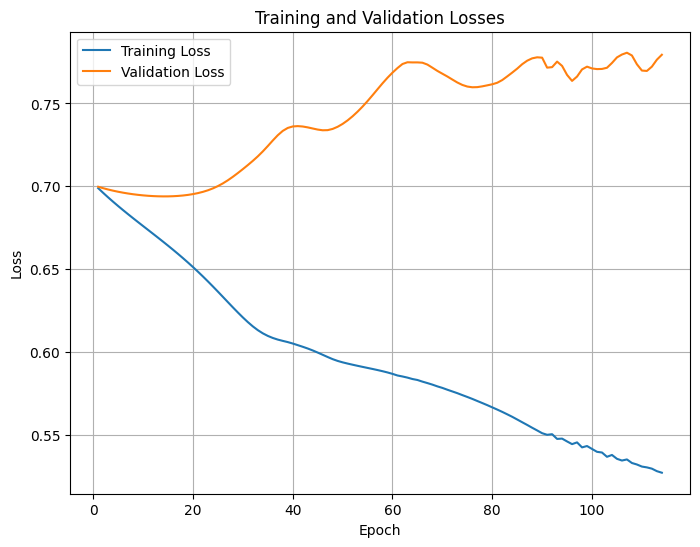

In [10]:
# Initialize empty lists to store training losses
train_losses = []
val_losses = []
val_loss_temp = float('inf')

# Training loop
n_epochs = 300
patience = og_patience = 100

for epoch in range(1, n_epochs+1):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.unsqueeze(1))
    loss.backward()
    optimizer.step()


    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor.unsqueeze(1))

    # Append losses to lists
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # save best model
    if val_loss.item() < val_loss_temp:
        best_model, best_epoch = copy.deepcopy(model), epoch
        val_loss_temp = val_loss.item()
        patience = og_patience + 1

    patience -= 1
    if patience == 0:
        print(f"\nNo progress in the last {og_patience} epochs. Training completed.")
        break
    
    # print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Training progress bar
    label = f"{epoch}/{n_epochs} epochs | val_loss = {val_loss.item():.4f}"
    progress = (epoch)/ n_epochs
    progress_bar_len = 50
    filled_len = int(progress_bar_len * progress)
    bar = '=' * filled_len + '-' * (progress_bar_len - filled_len)
    sys.stdout.write(f'\rTraining in progress: [{bar}] {progress * 100:.1f}% [{label}]')
    sys.stdout.flush()

# Plot the losses
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.grid(True)
plt.legend()
plt.show()

In [11]:
model = best_model
print(f"Best model at epoch {best_epoch}.")

Best model at epoch 14.


In [12]:
# # Create an instance of the LSTM model
# model = LSTMModel(n_features, hidden_size=64)

# # Load the saved weights
# model.load_state_dict(torch.load('lstm_model_0.485.pt'))
# model.eval()  # Set the model to evaluation mode
# optimal_threshold = 0.485

In [24]:
# Save the model
torch.save(model.state_dict(), f'lstm_model_skip2_{optimal_threshold:.3f}.pt')

In [14]:
# Find optimal threshold based on best F1-score
thresholds = np.arange(0, 1, 0.001)
precision = 0
recall = 0
f1_score = 0
f1_scores = []
optimal_threshold = 0
excluded_thresholds = []

for j, threshold in enumerate(thresholds):
    verdict = ''
    temp_vid_id = ''
    TP = FP = TN = FN = 0

    # Iterate through sequences
    seq_counter = 0
    for i, sequence in enumerate(X_test):
        input_data = torch.tensor(sequence[:, 2:].astype(np.float32), dtype=torch.float32)
        vid_id, frame_num = sequence[sequence_length-1, 0], sequence[sequence_length-1, 1]  # ID and frame of last row in the sequence
        
        # Check if it's the same video ID as before
        if vid_id == temp_vid_id:
            continue  # Ignore sequences from the same video if robbery prediction was already done
        
        # Make predictions
        with torch.no_grad():
            output = model(input_data.unsqueeze(0))  # Add batch dimension
            RBP = (output).squeeze().cpu().numpy()

        actualRBP = y_test[i]

        # Print progress bar
        n_seq = test_n_seq[vid_id]


        # Evaluate predictions
        if ((RBP >= threshold) & (actualRBP == 1)):
            verdict = 'TP'
            TP += 1
            temp_vid_id = vid_id
            seq_counter = 0
        elif ((RBP >= threshold) & (actualRBP == 0)):
            verdict = 'FP'
            FP += 1
            temp_vid_id = vid_id
            seq_counter = 0
        elif ((RBP < threshold) & (actualRBP == 0)):
            verdict = 'TN'
            seq_counter += 1
        elif ((RBP < threshold) & (actualRBP == 1)):
            verdict = 'FN'
            seq_counter += 1

        if seq_counter == n_seq:
            seq_counter = 0
            if verdict == 'TN':
                TN += 1
            else:
                FN += 1
    
    try:
        precision = TP / (TP+FP)
        recall = TP / (TP+FN)
        f1_score = 2*(precision*recall)/(precision+recall)

        if not (f1_scores):
            best_f1_score = f1_score
            optimal_threshold = threshold
            best_TP = TP
            best_TN = TN
            best_FP = FP
            best_FN = FN
        elif f1_score > best_f1_score:
            best_f1_score = f1_score
            optimal_threshold = threshold
            best_TP = TP
            best_TN = TN
            best_FP = FP
            best_FN = FN

        f1_scores.append(f1_score)
        f1_score = f'{f1_score:.3f}'


    except:
        excluded_thresholds.append(threshold)
        f1_score = None
    
    best_f1_score = round(best_f1_score, 4)
    optimal_threshold = round(optimal_threshold, 3)


     # Evaluation progress bar
    label = f"th = {threshold:.3f} | BEST: f1 = {best_f1_score} @ th = {optimal_threshold}"
    progress = (j+1)/ len(thresholds)
    progress_bar_len = 50
    filled_len = int(progress_bar_len * progress)
    bar = '=' * filled_len + '-' * (progress_bar_len - filled_len)
    sys.stdout.write(f'\rDetermining optimal threshold: [{bar}] {progress * 100:.1f}% [{label}]')
    sys.stdout.flush()

print(f"\nBest f1-score: {best_f1_score}")
print(f"optimal threshold: {optimal_threshold}")


Determining optimal threshold: [==================================================] 100.0% [th = 0.999 | BEST: f1 = 0.7458 @ th = 0.451]
Best f1-score: 0.7458
optimal threshold: 0.451


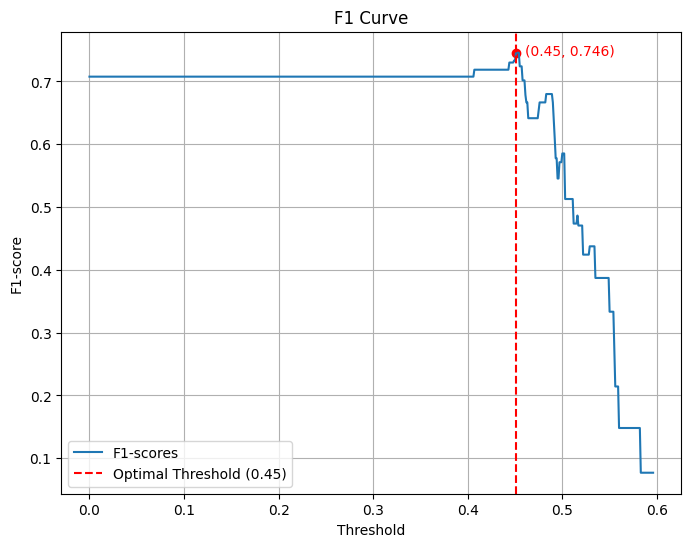

In [15]:
filtered_thresholds = thresholds[~np.isin(thresholds, excluded_thresholds)]

# Plot the F1 curve
plt.figure(figsize=(8, 6))
plt.plot(filtered_thresholds, f1_scores, label="F1-scores")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("F1 Curve")
plt.grid(True)

# Add vertical dashed red line at the optimal threshold
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f"Optimal Threshold ({optimal_threshold:.2f})")

# Annotate the intersection point
plt.scatter(optimal_threshold, best_f1_score, color='red', marker='o')
plt.annotate(f"({optimal_threshold:.2f}, {best_f1_score:.3f})", xy=(optimal_threshold, best_f1_score),
             xytext=(optimal_threshold + 0.01, best_f1_score - 0.005), color='red')

# Add legend in the lower left corner
plt.legend(loc='lower left')

plt.show()

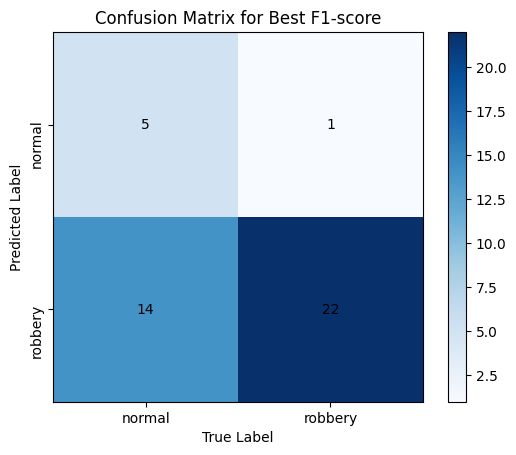

In [16]:
# Create the confusion matrix
conf_matrix = np.array([[best_TN, best_FP],
                         [best_FN, best_TP]])

# # Create the confusion matrix
# conf_matrix = np.array([[TN, FP],
#                          [FN, TP]])

# Transpose the matrix
conf_matrix_transposed = conf_matrix.T

# Plot the transposed confusion matrix
plt.imshow(conf_matrix_transposed, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xticks([0, 1], ['normal', 'robbery'])  # Set custom x-axis labels
plt.yticks([0, 1], ['normal', 'robbery'], rotation='vertical')  # Set custom y-axis labels

# Add text annotations
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_matrix_transposed[i, j]), ha='center', va='center', color='black')

plt.title('Confusion Matrix for Best F1-score')
plt.xlabel('True Label')  # Add x-axis label
plt.ylabel('Predicted Label')  # Add y-axis label
plt.show()


In [23]:
# Initialize variables
skip = 2 # skipped frames in scripting
verdict = ''
temp_vid_id = ''
TP = FP = TN = FN = 0

# Iterate through sequences
seq_counter = 0
for i, sequence in enumerate(X_test):
    input_data = torch.tensor(sequence[:, 2:].astype(np.float32), dtype=torch.float32)
    vid_id, frame_num = sequence[sequence_length-1, 0], sequence[sequence_length-1, 1]  # ID and frame of last row in the sequence
    
    # Check if it's the same video ID as before
    if vid_id == temp_vid_id:
        continue  # Ignore sequences from the same video if robbery prediction was already done
    
    # Make predictions
    with torch.no_grad():
        output = model(input_data.unsqueeze(0))  # Add batch dimension
        RBP = (output).squeeze().cpu().numpy()

    actualRBP = y_test[i]

    # Print progress bar
    n_seq = test_n_seq[vid_id]


    # Evaluate predictions
    if ((RBP >= optimal_threshold) & (actualRBP == 1)):
        verdict = 'TP'
        TP += 1
        temp_vid_id = vid_id
        seq_counter = 0
        print(f"\n{vid_id} | TRUE POSITIVE | ROBBERY correctly predicted @ {(frame_num*100/(n_seq*sequence_length*skip)):.4f}% of video.")
    elif ((RBP >= optimal_threshold) & (actualRBP == 0)):
        verdict = 'FP'
        FP += 1
        temp_vid_id = vid_id
        seq_counter = 0
        print(f"\n{vid_id} | FALSE POSITIVE | ROBBERY wrongly predicted @ {(frame_num*100/(n_seq*sequence_length*skip)):.4f}% of video.")
    elif ((RBP < optimal_threshold) & (actualRBP == 0)):
        verdict = 'TN'
        seq_counter += 1
    elif ((RBP < optimal_threshold) & (actualRBP == 1)):
        verdict = 'FN'
        seq_counter += 1

    if seq_counter == n_seq:
        seq_counter = 0
        if verdict == 'TN':
            TN += 1
            print(f"\n{vid_id} | TRUE NEGATIVE | NO ROBBERY correctly predicted.")
        else:
            FN += 1
            print(f"\n{vid_id} | FALSE NEGATIVE | NO ROBBERY wrongly predicted.")

print(f'\nTP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}')

try:
    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    f1_score = 2*(precision*recall)/(precision+recall)
except:
    threshold

print(f'Precision = {precision}, Recall = {recall}, F1-score = {f1_score}')



normal_trimmed_39.mp4 | TRUE NEGATIVE | NO ROBBERY correctly predicted.

anomaly_68.mp4 | TRUE POSITIVE | ROBBERY correctly predicted @ 6.2500% of video.

anomaly_32.mp4 | TRUE POSITIVE | ROBBERY correctly predicted @ 56.2500% of video.

normal_trimmed_50.mp4 | TRUE NEGATIVE | NO ROBBERY correctly predicted.

anomaly_43.mp4 | TRUE POSITIVE | ROBBERY correctly predicted @ 10.0000% of video.

anomaly_13.mp4 | TRUE POSITIVE | ROBBERY correctly predicted @ 4.3478% of video.

normal_trimmed_12.mp4 | FALSE POSITIVE | ROBBERY wrongly predicted @ 4.3478% of video.

anomaly_70.mp4 | TRUE POSITIVE | ROBBERY correctly predicted @ 9.0909% of video.

normal_trimmed_35.mp4 | FALSE POSITIVE | ROBBERY wrongly predicted @ 30.7692% of video.

normal_trimmed_40.mp4 | FALSE POSITIVE | ROBBERY wrongly predicted @ 3.8462% of video.

normal_trimmed_44.mp4 | TRUE NEGATIVE | NO ROBBERY correctly predicted.

anomaly_57.mp4 | TRUE POSITIVE | ROBBERY correctly predicted @ 40.6250% of video.

anomaly_67.mp4 | TRU

In [18]:
# # Find optimal threshold based on BEST ACCURACY
# thresholds = np.arange(0.001, 1, 0.001)
# accuracy = 0
# accuracies = []
# optimal_threshold = 0
# excluded_thresholds = []

# for j, threshold in enumerate(thresholds):
#     verdict = ''
#     temp_vid_id = ''
#     TP = FP = TN = FN = 0

#     # Iterate through sequences
#     seq_counter = 0
#     for i, sequence in enumerate(X_test):
#         input_data = torch.tensor(sequence[:, 2:].astype(np.float32), dtype=torch.float32)
#         vid_id, frame_num = sequence[sequence_length-1, 0], sequence[sequence_length-1, 1]  # ID and frame of last row in the sequence
        
#         # Check if it's the same video ID as before
#         if vid_id == temp_vid_id:
#             continue  # Ignore sequences from the same video if robbery prediction was already done
        
#         # Make predictions
#         with torch.no_grad():
#             output = model(input_data.unsqueeze(0))  # Add batch dimension
#             RBP = (output).squeeze().cpu().numpy()

#         actualRBP = y_test[i]

#         # Print progress bar
#         n_seq = test_n_seq[vid_id]


#         # Evaluate predictions
#         if ((RBP >= threshold) & (actualRBP == 1)):
#             verdict = 'TP'
#             TP += 1
#             temp_vid_id = vid_id
#             seq_counter = 0
#         elif ((RBP >= threshold) & (actualRBP == 0)):
#             verdict = 'FP'
#             FP += 1
#             temp_vid_id = vid_id
#             seq_counter = 0
#         elif ((RBP < threshold) & (actualRBP == 0)):
#             verdict = 'TN'
#             seq_counter += 1
#         elif ((RBP < threshold) & (actualRBP == 1)):
#             verdict = 'FN'
#             seq_counter += 1

#         if seq_counter == n_seq:
#             seq_counter = 0
#             if verdict == 'TN':
#                 TN += 1
#             else:
#                 FN += 1
    
#     try:
#         accuracy = (TP+TN)/(TP+TN+FP+FN)

#         if not (accuracies):
#             best_accuracy = accuracy
#             optimal_threshold = threshold
#             best_TP = TP
#             best_TN = TN
#             best_FP = FP
#             best_FN = FN
#         elif accuracy > best_accuracy:
#             best_accuracy = accuracy
#             optimal_threshold = threshold
#             best_TP = TP
#             best_TN = TN
#             best_FP = FP
#             best_FN = FN

#         accuracies.append(accuracy)
#         accuracy = f'{accuracy:.3f}'

#     except:
#         excluded_thresholds.append(threshold)
#         # accuracy = None
    

#      # Evaluation progress bar
#     label = f"th = {threshold:.3f} | BEST: accuracy = {best_accuracy:.3f} @ th = {optimal_threshold:.3f}"
#     progress = (j+1)/ len(thresholds)
#     progress_bar_len = 50
#     filled_len = int(progress_bar_len * progress)
#     bar = '=' * filled_len + '-' * (progress_bar_len - filled_len)
#     sys.stdout.write(f'\rDetermining optimal threshold: [{bar}] {progress * 100:.1f}% [{label}]')
#     sys.stdout.flush()

# print(f"\nBest accuracy: {best_accuracy}")
# print(f"optimal threshold: {optimal_threshold}")





# # Plot the f1 curve
# filtered_thresholds = thresholds[~np.isin(thresholds, excluded_thresholds)]
# plt.figure(figsize=(8, 6))
# plt.plot(filtered_thresholds, accuracies)
# plt.xlabel("Threshold")
# plt.ylabel("Accuracy")
# plt.title("Accuracy Curve")
# plt.grid(True)
# plt.show()




# # Create the confusion matrix
# conf_matrix = np.array([[best_TN, best_FP],
#                          [best_FN, best_TP]])

# # Transpose the matrix
# conf_matrix_transposed = conf_matrix.T

# # Plot the transposed confusion matrix
# plt.imshow(conf_matrix_transposed, cmap='Blues', interpolation='nearest')
# plt.colorbar()
# plt.xticks([0, 1], ['normal', 'robbery'])  # Set custom x-axis labels
# plt.yticks([0, 1], ['normal', 'robbery'], rotation='vertical')  # Set custom y-axis labels

# # Add text annotations
# for i in range(2):
#     for j in range(2):
#         plt.text(j, i, str(conf_matrix_transposed[i, j]), ha='center', va='center', color='black')

# plt.title('Confusion Matrix for Best Accuracy')
# plt.xlabel('True Label')  # Add x-axis label
# plt.ylabel('Predicted Label')  # Add y-axis label
# plt.show()


In [19]:
# # Find optimal threshold based on BEST PRECISION
# thresholds = np.arange(0.01, 1, 0.01)
# precision = 0
# precisions = []
# recall = 0
# f1_score = 0
# f1_scores = []
# optimal_threshold = 0
# excluded_thresholds = []

# for j, threshold in enumerate(thresholds):
#     verdict = ''
#     temp_vid_id = ''
#     TP = FP = TN = FN = 0

#     # Iterate through sequences
#     seq_counter = 0
#     for i, sequence in enumerate(X_test):
#         input_data = torch.tensor(sequence[:, 2:].astype(np.float32), dtype=torch.float32)
#         vid_id, frame_num = sequence[sequence_length-1, 0], sequence[sequence_length-1, 1]  # ID and frame of last row in the sequence
        
#         # Check if it's the same video ID as before
#         if vid_id == temp_vid_id:
#             continue  # Ignore sequences from the same video if robbery prediction was already done
        
#         # Make predictions
#         with torch.no_grad():
#             output = model(input_data.unsqueeze(0))  # Add batch dimension
#             RBP = (output).squeeze().cpu().numpy()

#         actualRBP = y_test[i]

#         # Print progress bar
#         n_seq = test_n_seq[vid_id]


#         # Evaluate predictions
#         if ((RBP >= threshold) & (actualRBP == 1)):
#             verdict = 'TP'
#             TP += 1
#             temp_vid_id = vid_id
#             seq_counter = 0
#         elif ((RBP >= threshold) & (actualRBP == 0)):
#             verdict = 'FP'
#             FP += 1
#             temp_vid_id = vid_id
#             seq_counter = 0
#         elif ((RBP < threshold) & (actualRBP == 0)):
#             verdict = 'TN'
#             seq_counter += 1
#         elif ((RBP < threshold) & (actualRBP == 1)):
#             verdict = 'FN'
#             seq_counter += 1

#         if seq_counter == n_seq:
#             seq_counter = 0
#             if verdict == 'TN':
#                 TN += 1
#             else:
#                 FN += 1
    
#     try:
#         precision = TP / (TP+FP)
#         # recall = TP / (TP+FN)
#         # f1_score = 2*(precision*recall)/(precision+recall)

#         if not (precisions):
#             best_precision = precision
#             # best_f1_score = f1_score
#             optimal_threshold = threshold
#             best_TP = TP
#             best_TN = TN
#             best_FP = FP
#             best_FN = FN
#         elif precision > best_precision:
#             best_precision = precision
#             # best_f1_score = f1_score
#             optimal_threshold = threshold
#             best_TP = TP
#             best_TN = TN
#             best_FP = FP
#             best_FN = FN

#         # f1_scores.append(f1_score)
#         # f1_score = f'{f1_score:.3f}'

#         # Based on precision
#         precisions.append(precision)
#         precision = f'{precision:.3f}'

#     except:
#         excluded_thresholds.append(threshold)
#         # f1_score = None
    

#      # Evaluation progress bar
#     # label = f"th = {threshold:.2f} | BEST: f1 = {best_f1_score} @ th = {optimal_threshold}"
#     label = f"th = {threshold:.3f} | BEST: prec = {best_precision:.3f} @ th = {optimal_threshold:.3f}"
#     progress = (j+1)/ len(thresholds)
#     progress_bar_len = 50
#     filled_len = int(progress_bar_len * progress)
#     bar = '=' * filled_len + '-' * (progress_bar_len - filled_len)
#     sys.stdout.write(f'\rDetermining optimal threshold: [{bar}] {progress * 100:.1f}% [{label}]')
#     sys.stdout.flush()

# print(f"\nBest precision: {best_precision}")
# print(f"optimal threshold: {optimal_threshold}")



# filtered_thresholds = thresholds[~np.isin(thresholds, excluded_thresholds)]

# # Plot the f1 curve
# plt.figure(figsize=(8, 6))
# plt.plot(filtered_thresholds, f1_scores)
# plt.xlabel("Threshold")
# plt.ylabel("Precision")
# plt.title("Precision Curve")
# plt.grid(True)
# plt.show()



# # Create the confusion matrix
# conf_matrix = np.array([[best_TN, best_FP],
#                          [best_FN, best_TP]])

# # Transpose the matrix
# conf_matrix_transposed = conf_matrix.T

# # Plot the transposed confusion matrix
# plt.imshow(conf_matrix_transposed, cmap='Blues', interpolation='nearest')
# plt.colorbar()
# plt.xticks([0, 1], ['normal', 'robbery'])  # Set custom x-axis labels
# plt.yticks([0, 1], ['normal', 'robbery'], rotation='vertical')  # Set custom y-axis labels

# # Add text annotations
# for i in range(2):
#     for j in range(2):
#         plt.text(j, i, str(conf_matrix_transposed[i, j]), ha='center', va='center', color='black')

# plt.title('Confusion Matrix for Best Precision')
# plt.xlabel('True Label')  # Add x-axis label
# plt.ylabel('Predicted Label')  # Add y-axis label
# plt.show()